# 2D Instance Segmentation with Discriminative Instance Loss
---
Implemntation of paper:
    
[Semantic Instance Segmentation with a Discriminative Loss Function](https://arxiv.org/abs/1708.02551)

In [1]:
import os
import errno

import numpy as np

import deepcell

## Load the data

### Download the data from `deepcell.datasets`

`deepcell.datasets` provides access to a set of annotated live-cell imaging datasets which can be used for training cell segmentation and tracking models.
All dataset objects share the `load_data()` method, which allows the user to specify the name of the file (`path`), the fraction of data reserved for testing (`test_size`) and a `seed` which is used to generate the random train-test split.
Metadata associated with the dataset can be accessed through the `metadata` attribute.

In [2]:
# Download the data (saves to ~/.keras/datasets)
filename = 'HeLa_S3.npz'
(X_train, y_train), (X_test, y_test) = deepcell.datasets.hela_s3.load_data(filename)

print('X.shape: {}\ny.shape: {}'.format(X_train.shape, y_train.shape))

3432783872/3432776206 [==============================] - 67s 0us/step
X.shape: (6208, 216, 256, 1)
y.shape: (6208, 216, 256, 1)


### Set up filepath constants

In [3]:
# the path to the data file is currently required for `train_model_()` functions

# change DATA_DIR if you are not using `deepcell.datasets`
DATA_DIR = os.path.expanduser(os.path.join('~', '.keras', 'datasets'))

# DATA_FILE should be a npz file, preferably from `make_training_data`
DATA_FILE = os.path.join(DATA_DIR, filename)

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

In [4]:
# Set up other required filepaths

# If the data file is in a subdirectory, mirror it in MODEL_DIR and LOG_DIR
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)

ROOT_DIR = '/data'  # TODO: Change this! Usually a mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# create directories if they do not exist
for d in (MODEL_DIR, LOG_DIR):
    try:
        os.makedirs(d)
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

## Create the Foreground/Background FeatureNet Model

Here we instantiate two `FeatureNet` models from `deepcell.model_zoo` for foreground/background separation as well as the interior/edge segmentation.

In [5]:
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data
n_skips = 1  # number of skip-connections (only for FC training)

In [6]:
from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    receptive_field=receptive_field,
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    norm_method=norm_method,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

## Prepare for training

### Set up training parameters.

There are a number of tunable hyper parameters necessary for training deep learning models:

**model_name**: Incorporated into any files generated during the training process.

**n_epoch**: The number of complete passes through the training dataset.

**lr**: The learning rate determines the speed at which the model learns. Specifically it controls the relative size of the updates to model values after each batch.

**optimizer**: The TensorFlow module [tf.keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) offers optimizers with a variety of algorithm implementations. DeepCell typically uses the Adam or the SGD optimizers.

**lr_sched**: A learning rate scheduler allows the learning rate to adapt over the course of model training. Typically a larger learning rate is preferred during the start of the training process, while a small learning rate allows for fine-tuning during the end of training.

**batch_size**: The batch size determines the number of samples that are processed before the model is updated. The value must be greater than one and less than or equal to the number of samples in the training dataset.

In [7]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'disc_fgbg'
disc_2d_model_name = 'disc_2d'
disc_3d_model_name = 'disc_3d'

n_epoch = 1  # Number of training epochs

lr = 0.01
lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1  # FC training uses 1 image per batch

### Create the DataGenerators

The `ImageFullyConvDataGenerator` outputs a raw image (`X`) with it's labeled annotation mask (`y`). Additionally, it can apply a transform to `y` to change the task the model learns. Below we generate 2 training and validation data sets for both the foreground/background model and the pixelwise model.

In [8]:
from deepcell.image_generators import ImageFullyConvDataGenerator

datagen = ImageFullyConvDataGenerator(
    rotation_range=180,
    zoom_range=(.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = ImageFullyConvDataGenerator()

In [9]:
# Create the foreground/background data iterators

fgbg_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    skip=n_skips,
    transform='fgbg',
    batch_size=batch_size)

fgbg_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    skip=n_skips,
    transform='fgbg',
    batch_size=batch_size)

In [10]:
# Create the pixelwise data iterators

disc_train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    skip=n_skips,
    transform='disc',
    batch_size=batch_size)

disc_val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    skip=n_skips,
    transform='disc',
    batch_size=batch_size)

### Compile the model with a loss function

Each model is trained with it's own loss function. `weighted_categorical_crossentropy` is often used for classification models, and `disc_loss` is used for the discriminative instance models.

In [11]:
from deepcell import losses

def loss_function(y_true, y_pred):
    return losses.weighted_categorical_crossentropy(
        y_true, y_pred,
        n_classes=2,
        from_logits=False)

fgbg_model.compile(
    loss=loss_function,
    optimizer=SGD(learning_rate=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the foreground/background model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [12]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(fgbg_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = fgbg_model.fit(
    fgbg_train_data,
    steps_per_epoch=fgbg_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=fgbg_val_data,
    validation_steps=fgbg_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs
Epoch 1/8
6207/6208 [============================>.] - ETA: 0s - loss: 0.1848 - model_loss: 0.0867 - model_1_loss: 0.0840 - model_acc: 0.9682 - model_1_acc: 0.9676
Epoch 00001: val_loss improved from inf to 0.13585, saving model to /data/models/disc_fgbg.h5
6208/6208 [==============================] - 487s 78ms/step - loss: 0.1848 - model_loss: 0.0867 - model_1_loss: 0.0840 - model_acc: 0.9682 - model_1_acc: 0.9676 - val_loss: 0.1358 - val_model_loss: 0.0584 - val_model_1_loss: 0.0633 - val_model_acc: 0.9754 - val_model_1_acc: 0.9664
Epoch 2/8
6207/6208 [============================>.] - ETA: 0s - loss: 0.1627 - model_loss: 0.0757 - model_1_loss: 0.0729 - model_acc: 0.9712 - model_1_acc: 0.9713
Epoch 00002: val_loss improved from 0.13585 to 0.12553, saving model to /data/models/disc_fgbg.h5
6208/6208 [==============================] - 474s 76ms/step - loss: 0.1627 - model_loss: 0.0757 - model_1_loss: 0.0729 - model_acc: 0.9712 - model_1_acc: 0.9713 - val_loss: 0.1255

## Create the 2D vector embedding FeatureNet Model

Instatiate a `FeatureNet` for discriminative instance loss, which maps each pixel to a N-dimensional vector.

In [13]:
from deepcell import model_zoo

disc_2d_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=2,  # Embedding dimensions
    n_dense_filters=128,
    n_conv_filters=32,
    last_only=False,
    include_top=False,  # remove softmax layer
    location=True,
    input_shape=tuple(X_train.shape[1:]),
    norm_method=norm_method)

### Compile the model with a loss function

Just like the foreground/background model, the `disc` model is compiled with the discriminative instance loss (`disc_loss`) function.

In [14]:
from deepcell import losses

disc_2d_model.compile(
    loss=losses.discriminative_instance_loss,
    optimizer=SGD(learning_rate=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the 2D vector embedding `disc` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [15]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(disc_2d_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(disc_2d_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = disc_2d_model.fit(
    disc_train_data,
    steps_per_epoch=disc_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=disc_val_data,
    validation_steps=disc_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs
Epoch 1/8
6207/6208 [============================>.] - ETA: 0s - loss: 8.2852 - model_3_loss: 4.1329 - model_4_loss: 4.1246 - model_3_acc: 0.9238 - model_4_acc: 0.0525
Epoch 00001: val_loss improved from inf to 7.36992, saving model to /data/models/disc_2d.h5
6208/6208 [==============================] - 822s 132ms/step - loss: 8.2851 - model_3_loss: 4.1329 - model_4_loss: 4.1246 - model_3_acc: 0.9238 - model_4_acc: 0.0525 - val_loss: 7.3699 - val_model_3_loss: 3.6613 - val_model_4_loss: 3.6809 - val_model_3_acc: 0.9208 - val_model_4_acc: 0.0221
Epoch 2/8
6207/6208 [============================>.] - ETA: 0s - loss: 8.2393 - model_3_loss: 4.1089 - model_4_loss: 4.1028 - model_3_acc: 0.9244 - model_4_acc: 0.0294
Epoch 00002: val_loss did not improve from 7.36992
6208/6208 [==============================] - 812s 131ms/step - loss: 8.2397 - model_3_loss: 4.1090 - model_4_loss: 4.1029 - model_3_acc: 0.9244 - model_4_acc: 0.0294 - val_loss: 7.3958 - val_model_3_loss: 3.6842

## Predict on test data

Use the trained model to predict on new data and post-process the results into a label mask.

In [16]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images_fgbg = fgbg_model.predict(X_test)[-1]
fgbg_time = default_timer() - start

start = default_timer()
test_images_2d = disc_2d_model.predict(X_test)[-1]
disc_time = default_timer() - start

print('fgbg segmentation of shape', test_images_fgbg.shape, 'in', fgbg_time)
print('disc segmentation of shape', test_images_2d.shape, 'in', disc_time)

fgbg segmentation of shape (1552, 216, 256, 2) in 23.66609274270013
disc segmentation of shape (1552, 216, 256, 2) in 42.482446641195565


### Post-processing

In [17]:
# threshold the foreground/background
# and remove background from vector embedding
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)
test_images_2d_post_fgbg = test_images_2d * fg_thresh

print(test_images_2d_post_fgbg.shape)

(1552, 216, 256, 2)


#### Mean Shift

In [18]:
from itertools import cycle
from sklearn.cluster import MeanShift, estimate_bandwidth

def fit_mean_shift(images, index, ndim, n_samples=500):
    test_plot = images[index].reshape(-1, ndim)
    bandwidth = estimate_bandwidth(test_plot, n_samples=n_samples)

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(test_plot)
    return ms

ms = fit_mean_shift(test_images_2d_post_fgbg, index=0, ndim=2, n_samples=500)

#### DBSCAN

In [19]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

def fit_dbscan(images, index, ndim, eps=.15):
    test_plot = images[index].reshape(-1, ndim)
    db = DBSCAN(eps=eps, min_samples=5, algorithm='kd_tree').fit(test_plot)
    return db

db = fit_dbscan(test_images_2d_post_fgbg, index=0, ndim=2, eps=0.12)

### Plot the Results

#### Scatter plot of the 2D Vectors

Image number: 225


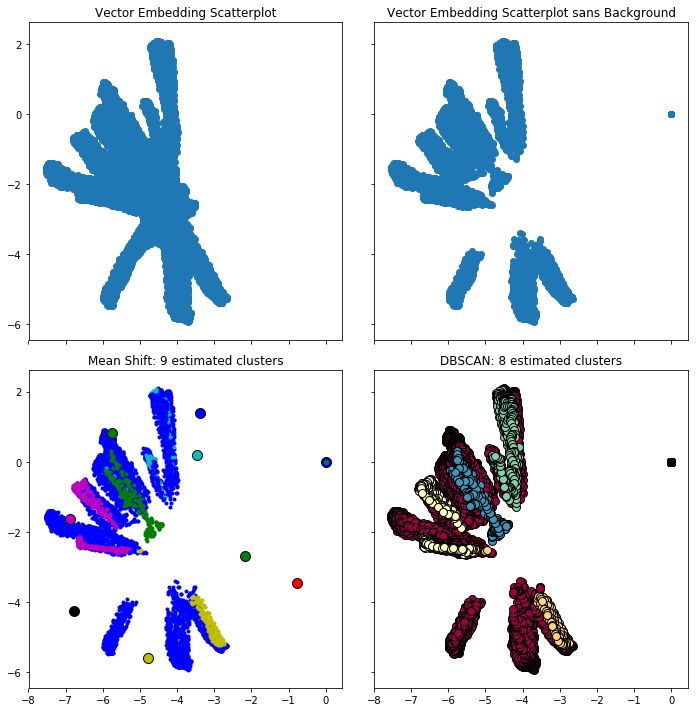

In [20]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

# Scatterplot of all pixels 2D Vector Embeddings
test_plot = test_images_2d[index].reshape(-1, 2)
ax[0].scatter(x=test_plot[:, 0], y=test_plot[:, 1])
ax[0].set_title('Vector Embedding Scatterplot')

# Scatterplot of non-background pixels 2D Vector Embeddings
test_plot = test_images_2d_post_fgbg[index].reshape(-1, 2)
ax[1].scatter(x=test_plot[:, 0], y=test_plot[:, 1])
ax[1].set_title('Vector Embedding Scatterplot sans Background')

# Scatter Plot for MeanShift Clustering
for k, col in zip(range(np.unique(ms.labels_).size), cycle('bgrcmyk')):
    my_members = ms.labels_ == k
    cluster_center = ms.cluster_centers_[k]
    ax[2].plot(test_plot[my_members, 0], test_plot[my_members, 1], col + '.')
    ax[2].plot(cluster_center[0], cluster_center[1], 'o',
               markerfacecolor=col, markeredgecolor='k', markersize=10)
ax[2].set_title('Mean Shift: %d estimated clusters' % len(np.unique(ms.labels_)))

# Scatter Plot for DBSCAN Clustering
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black used for noise.

    class_member_mask = (db.labels_ == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    ax[3].plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5)

# Number of clusters in labels, ignoring noise if present.
db_n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
ax[3].set_title('DBSCAN: %d estimated clusters' % db_n_clusters_)

fig.tight_layout()
plt.show()

### Plot the results for 2D embedding

Image number: 1198


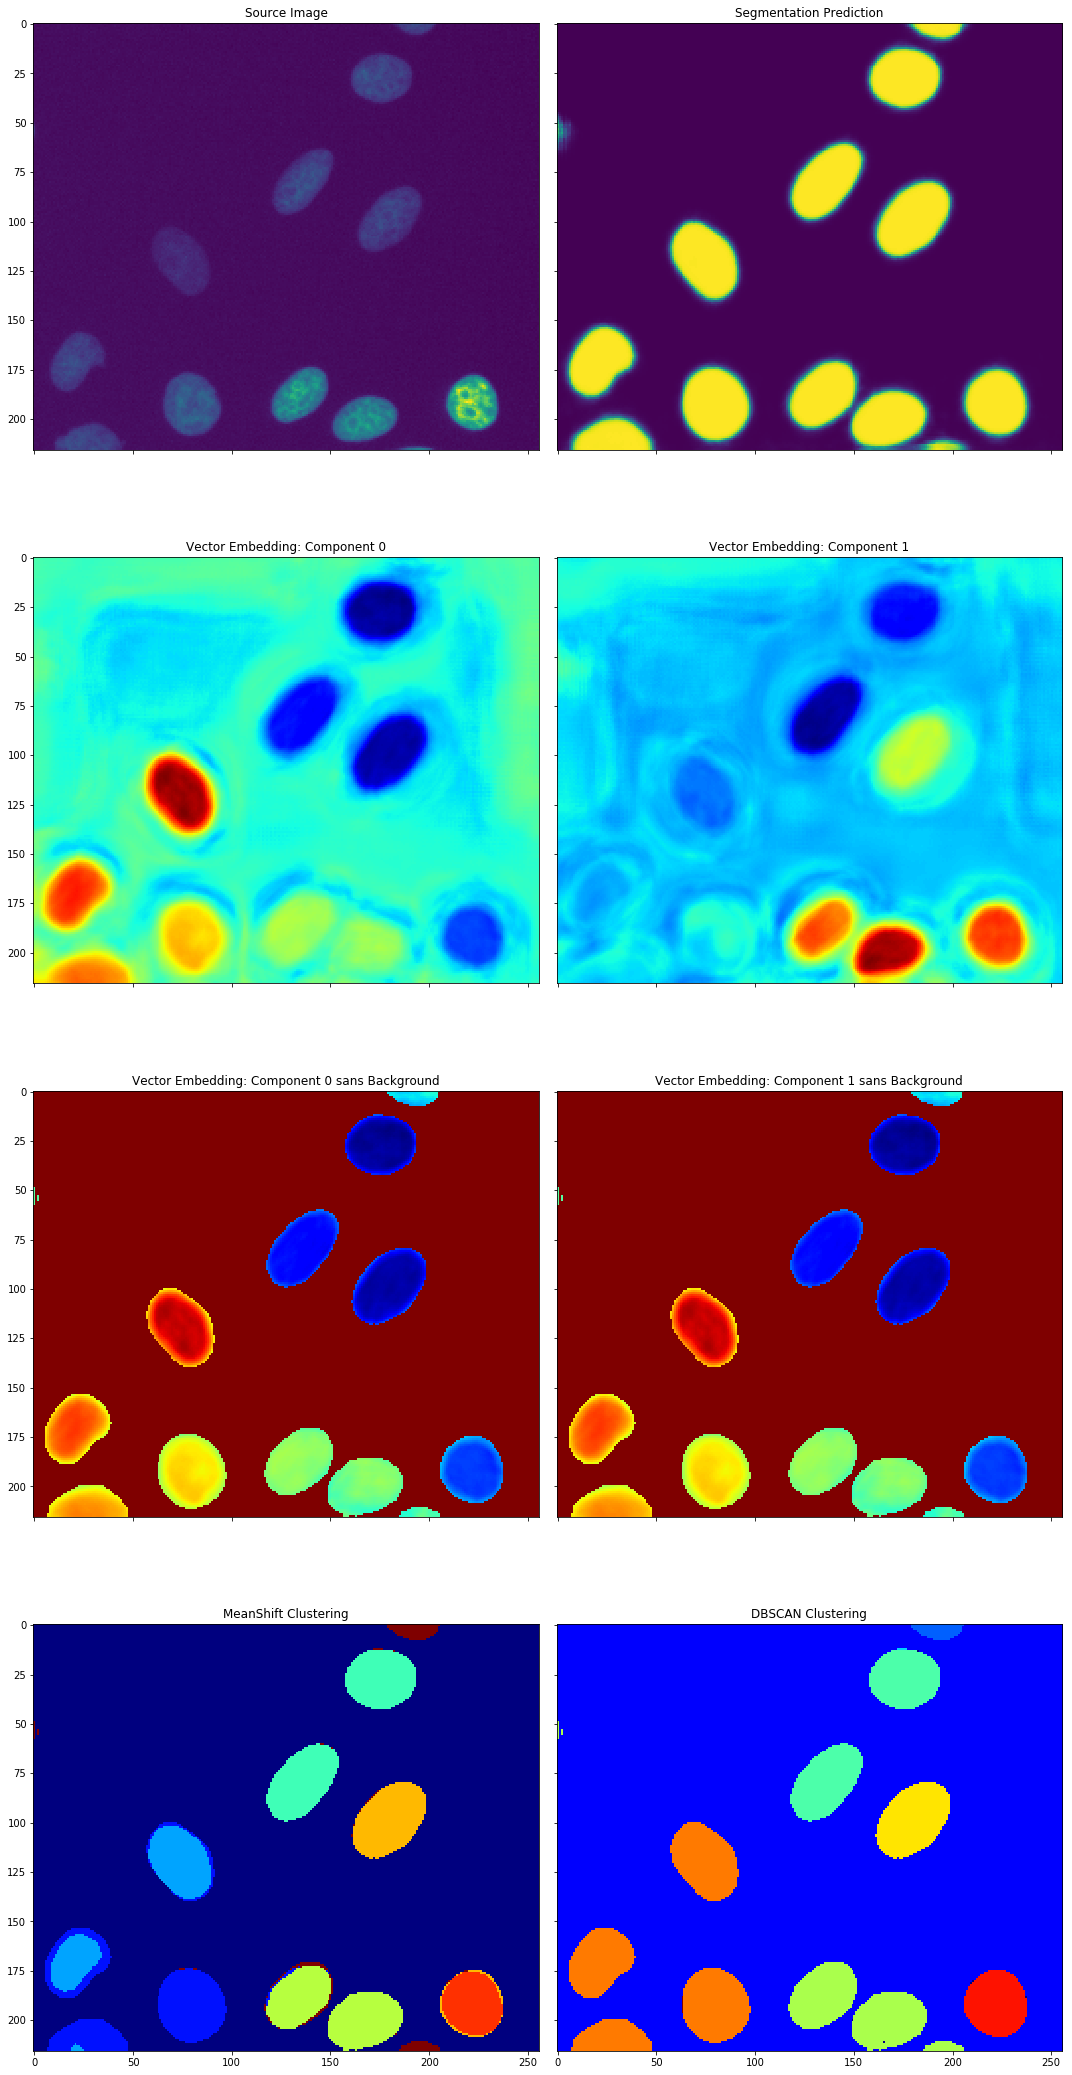

In [21]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images_2d[index, ..., 0], cmap='jet')
ax[2].set_title('Vector Embedding: Component 0')

ax[3].imshow(test_images_2d[index, ..., 1], cmap='jet')
ax[3].set_title('Vector Embedding: Component 1')

ax[4].imshow(test_images_2d_post_fgbg[index, ..., 0], cmap='jet')
ax[4].set_title('Vector Embedding: Component 0 sans Background')

ax[5].imshow(test_images_2d_post_fgbg[index, ..., 0], cmap='jet')
ax[5].set_title('Vector Embedding: Component 1 sans Background')

ms = fit_mean_shift(test_images_2d_post_fgbg, index=index, ndim=2, n_samples=500)
ax[6].imshow(ms.labels_.reshape(test_images_2d_post_fgbg.shape[1:-1]), cmap='jet')
ax[6].set_title('MeanShift Clustering')

db = fit_dbscan(test_images_2d_post_fgbg, index=index, ndim=2, eps=0.12)
ax[7].imshow(db.labels_.reshape(test_images_2d_post_fgbg.shape[1:-1]), cmap='jet')
ax[7].set_title('DBSCAN Clustering')

fig.tight_layout()
plt.show()

### Finally, Create a 3D vector embedding `disc` model

The previous `disc` model mapped every pixel to a 2D vector space. We can also try mapping to a 3D vector space to see if it has improved instance discrimination performance.

In [22]:
from deepcell import model_zoo

disc_3d_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=3,  # Embedding dimensions
    n_dense_filters=128,
    n_conv_filters=32,
    location=True,
    last_only=False,
    include_top=False,  # remove softmax layer
    input_shape=tuple(X_train.shape[1:]),
    norm_method=norm_method)

### Compile the model with a loss function

Just like the foreground/background model, the `disc` model is compiled with the discriminative instance loss (`disc_loss`) function.

In [23]:
from deepcell import losses

disc_3d_model.compile(
    loss=losses.discriminative_instance_loss,
    optimizer=SGD(learning_rate=lr, decay=1e-6, momentum=0.9, nesterov=True),
    metrics=['accuracy'])

## Train the 3D vector embedding `disc` model

Call `fit()` on the compiled model, along with a default set of callbacks.

In [24]:
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_path = os.path.join(MODEL_DIR, '{}.h5'.format(disc_3d_model_name))
loss_path = os.path.join(MODEL_DIR, '{}.npz'.format(disc_3d_model_name))

num_gpus = count_gpus()

print('Training on', num_gpus, 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    save_weights_only=num_gpus >= 2,
    monitor='val_loss',
    verbose=1)

loss_history = disc_3d_model.fit(
    pixelwise_train_data,
    steps_per_epoch=disc_train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=disc_val_data,
    validation_steps=disc_val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

X_train shape: (6208, 216, 256, 1)
y_train shape: (6208, 216, 256, 1)
X_test shape: (1552, 216, 256, 1)
y_test shape: (1552, 216, 256, 1)
Output Shape: (None, 216, 256, 3)
Number of Classes: 3
Training on 1 GPUs
Epoch 1/8
6207/6208 [============================>.] - ETA: 0s - loss: 8.2081 - model_9_loss: 4.0928 - model_10_loss: 4.0878 - model_9_acc: 0.9242 - model_10_acc: 0.9250
Epoch 00001: val_loss improved from inf to 7.29739, saving model to /data/models/disc_3d.h5
6208/6208 [==============================] - 818s 132ms/step - loss: 8.2079 - model_9_loss: 4.0927 - model_10_loss: 4.0877 - model_9_acc: 0.9242 - model_10_acc: 0.9250 - val_loss: 7.2974 - val_model_9_loss: 3.6175 - val_model_10_loss: 3.6524 - val_model_9_acc: 0.9192 - val_model_10_acc: 0.9194
Epoch 2/8
6207/6208 [============================>.] - ETA: 0s - loss: 8.1715 - model_9_loss: 4.0744 - model_10_loss: 4.0697 - model_9_acc: 0.9254 - model_10_acc: 0.9252
Epoch 00002: val_loss improved from 7.29739 to 7.28312, savin

## Predict on test data

Use the trained model to predict on new data and post-process the results into a label mask.

In [25]:
test_images_3d = disc_3d_model.predict(X_test)[-1]
test_images_fgbg = fgbg_model.predict(X_test)[-1]

print(test_images_3d.shape)

(1552, 216, 256, 3)


### Post Processing

In [26]:
# threshold the foreground/background
# and remove background from vector embedding
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold
fg_thresh = np.expand_dims(fg_thresh, axis=-1)
test_images_3d_post_fgbg = test_images_3d * fg_thresh

### Scatter plot of the 3D Vectors

Image number: 1198


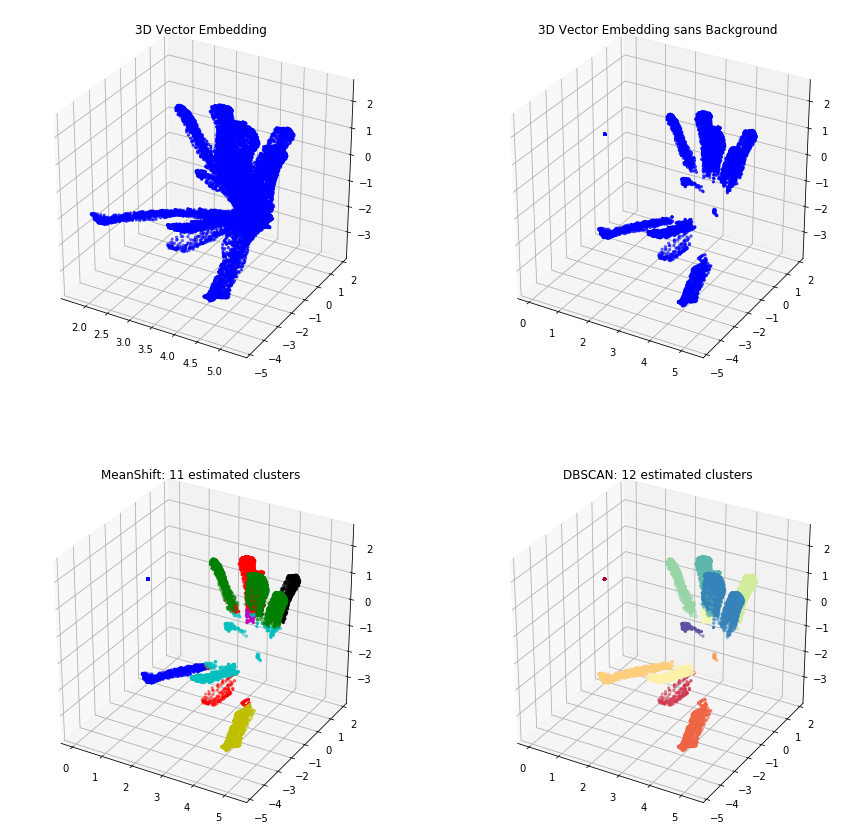

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig = plt.figure(figsize=(15, 15))

# 3D Vector Embedding
ax = fig.add_subplot(221, projection='3d')
test_plot = test_images_3d[index].reshape(-1, 3)
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)
ax.set_title('3D Vector Embedding')

# 3D Vector Embedding sans Background
ax = fig.add_subplot(222, projection='3d')
test_plot = test_images_3d_post_fgbg[index].reshape(-1, 3)
ax.scatter(test_plot[:, 0], test_plot[:, 1], test_plot[:, 2], c='b', marker='o', s=5)
ax.set_title('3D Vector Embedding sans Background')

# Scatter plot after MeanShift
ms = fit_mean_shift(test_images_3d_post_fgbg, index=index, ndim=3, n_samples=2000)
n_clusters_ms = np.unique(ms.labels_).size
ax = fig.add_subplot(223, projection='3d')
for k, col in zip(range(n_clusters_ms), cycle('bgrcmyk')):
    my_members = ms.labels_ == k
    ax.scatter(test_plot[my_members, 0],
               test_plot[my_members, 1],
               test_plot[my_members, 2],
               c=col, s=5)
ax.set_title('MeanShift: %d estimated clusters' % np.unique(ms.labels_).size)

# Scatter plot after DBSCAN
db = fit_dbscan(test_images_3d_post_fgbg, index=index, ndim=3, eps=0.2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_db = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

ax = fig.add_subplot(224, projection='3d')

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Scatter plot after DBScan
unique_labels = set(db.labels_)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black used for noise.

    class_member_mask = (db.labels_ == k)

    xy = test_plot[class_member_mask & core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=col, s=5)

    xy = test_plot[class_member_mask & ~core_samples_mask]
    ax.scatter(xy[:, 0], xy[:, 1], xy[:, 2], 'o', c=col, s=5)

ax.set_title('DBSCAN: %d estimated clusters' % n_clusters_db)

plt.show()

### Plot the results for 3D embedding

Image number: 1198


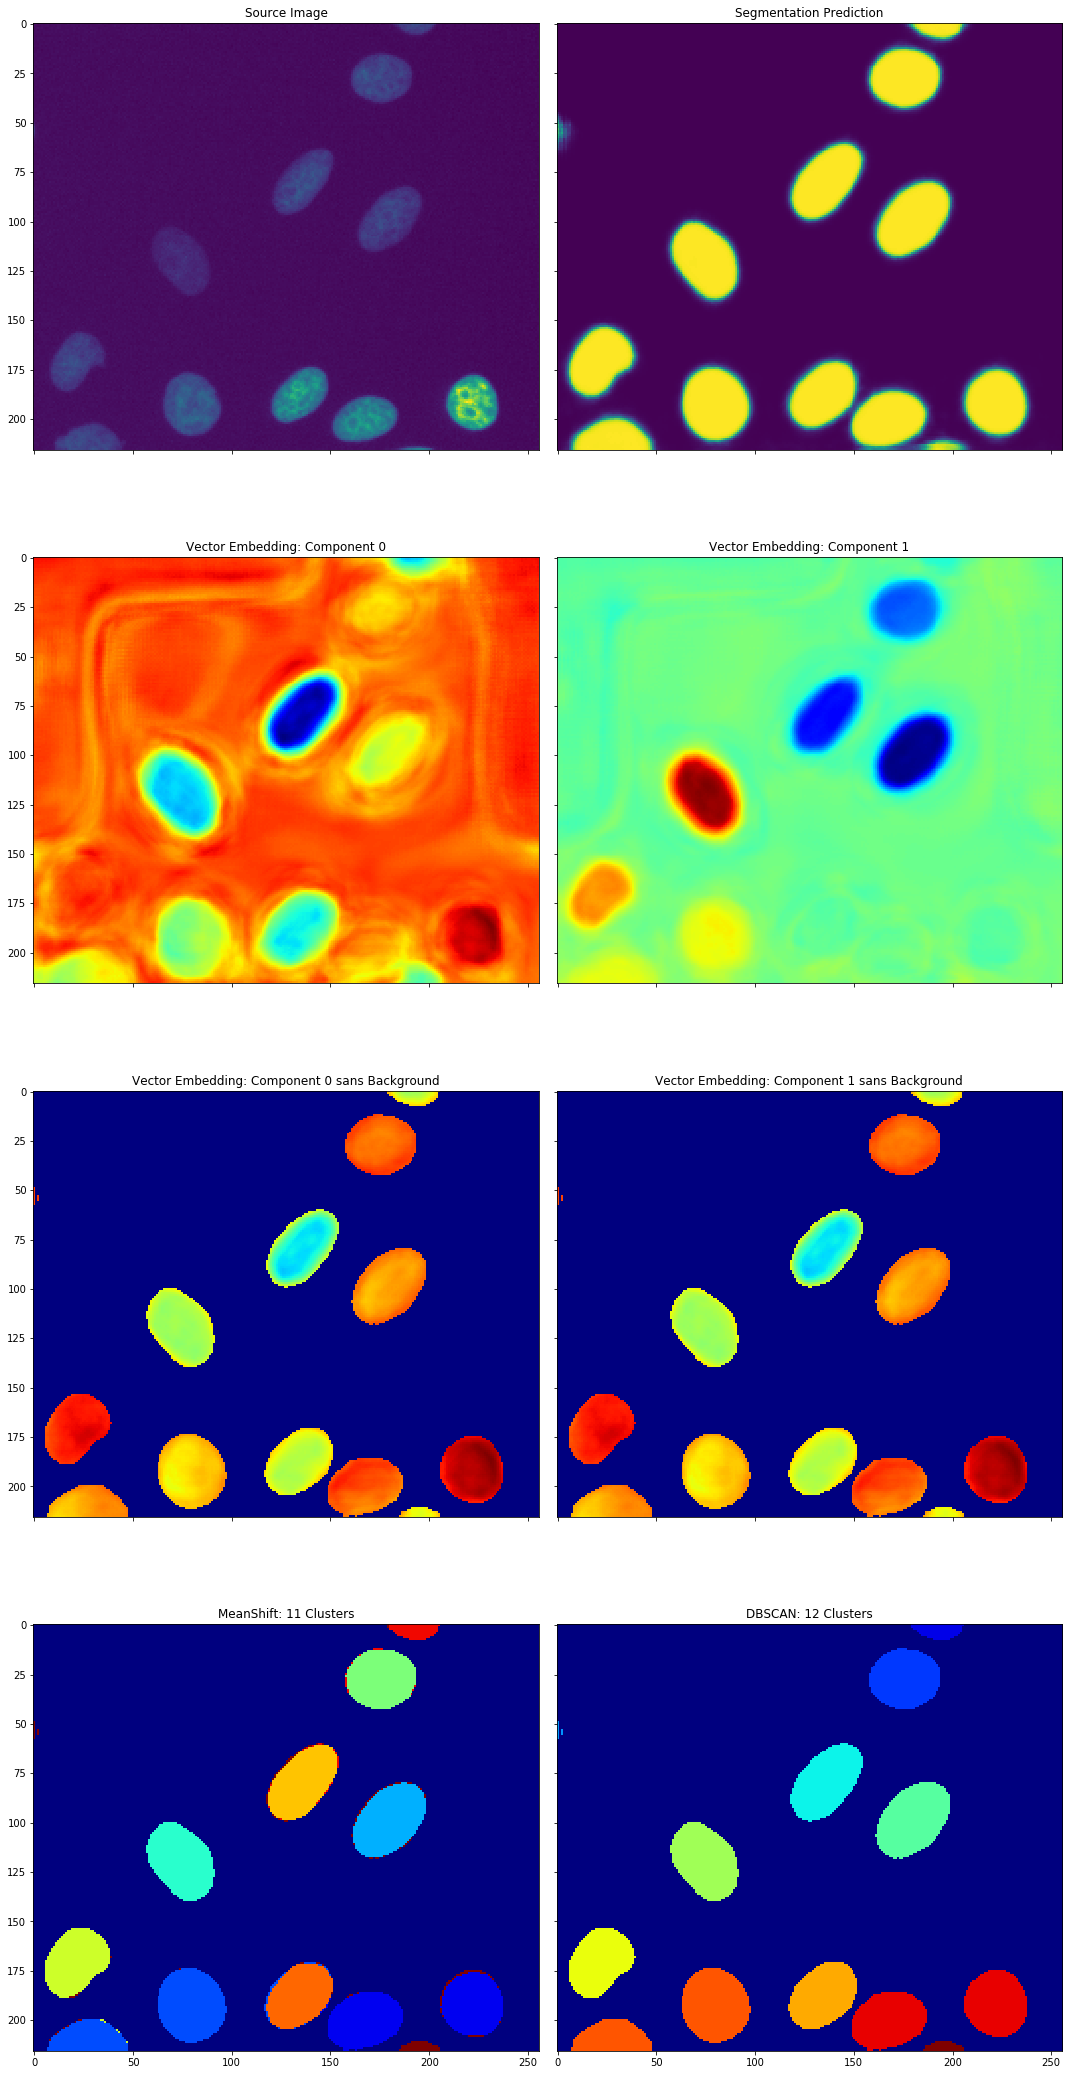

In [28]:
import matplotlib.pyplot as plt

index = np.random.randint(low=0, high=X_test.shape[0])
print('Image number:', index)

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(15, 30), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(test_images_3d[index, ..., 0], cmap='jet')
ax[2].set_title('Vector Embedding: Component 0')

ax[3].imshow(test_images_3d[index, ..., 1], cmap='jet')
ax[3].set_title('Vector Embedding: Component 1')

ax[4].imshow(test_images_3d_post_fgbg[index, ..., 0], cmap='jet')
ax[4].set_title('Vector Embedding: Component 0 sans Background')

ax[5].imshow(test_images_3d_post_fgbg[index, ..., 0], cmap='jet')
ax[5].set_title('Vector Embedding: Component 1 sans Background')

ms = fit_mean_shift(test_images_3d_post_fgbg, index=index, ndim=3, n_samples=2000)
ax[6].imshow(ms.labels_.reshape(test_images_3d_post_fgbg.shape[1:-1]), cmap='jet')
ax[6].set_title('MeanShift: %d Clusters' % np.unique(ms.labels_).size)

db = fit_dbscan(test_images_3d_post_fgbg, index=index, ndim=3, eps=0.2)
ax[7].imshow(db.labels_.reshape(test_images_3d_post_fgbg.shape[1:-1]), cmap='jet')
ax[7].set_title('DBSCAN: %d Clusters' % (len(set(db.labels_)) - int(-1 in db.labels_)))

fig.tight_layout()
plt.show()